In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet
import datetime as dt
import numpy as np
import sqlite3

### Importing data for time-series analysis
The following analysis uses the heirarchy CensusTracts -> Demographic Clusters -> City 
Demographic clusters were identified based on features that were found to have significant impact on 911 call volumes/area. 

A similar analysis was also performed using heriarchy CensusTracts -> Districts -> City where, districts are the 9 districts of Baltimore city (N, W, E, C, SE, SW, S, NE, NW).
Using the demographic clusters gave an additional impeovement of 10%. However, using the city level districts is far more practical from a decision making stand-point and therefore was finally chosen as the model for prediction.

In [5]:
connection = sqlite3.connect('C:/Users/tsen6/Desktop/Python/Baltimore_911_01.db')
cursor = connection.cursor()
sql = """
SELECT RecordID, CallDateTime, Priority, Census_Tracts, PoliceDistrict
FROM (SELECT r.RecordID, r.CallDateTime, d.Priority, l.Census_Tracts, l.PoliceDistrict
FROM RecordID r
INNER JOIN DetailsID d ON r.RecordID = d.RecordID
INNER JOIN LocationID l ON r.RecordID = l.RecordID
WHERE (d.Priority = 'High') OR (d.Priority = 'Medium'))
"""

dfHighEmer = pd.read_sql(sql, con=connection)
dfHighEmer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4065953 entries, 0 to 4065952
Data columns (total 5 columns):
 #   Column          Dtype  
---  ------          -----  
 0   RecordID        int64  
 1   CallDateTime    object 
 2   Priority        object 
 3   Census_Tracts   float64
 4   PoliceDistrict  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 155.1+ MB


In [9]:
# dfDes = pd.DataFrame(data = dfHighEmer['Description'].unique())
# dfDes.to_csv('Descriptions.csv')
dfHighEmer['Count']=1
dfHighEmer['CallDateTime'] = pd.to_datetime(dfHighEmer['CallDateTime'])

In [10]:
dfSum = dfHighEmer['Count'].groupby(dfHighEmer['CallDateTime'].dt.date).sum()
dfSum = pd.DataFrame(data=dfSum)
dfSum = dfSum.reset_index()
dfSum = dfSum.rename(columns={"CallDateTime": "ds","Count":"y"})
dfSum['ds'] = pd.to_datetime(dfSum['ds'])
dfSum['y0']=1

# startDate = dt.date(2015, 3, 8)
# stopDate = dt.date(2018, 12, 31)

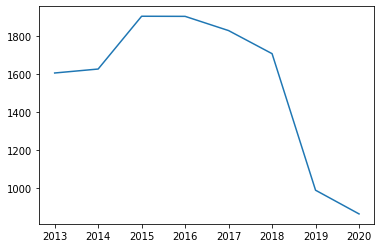

In [11]:
means = dfSum['y'].groupby(dfSum['ds'].dt.year).mean()
plt.plot(means)

mean1, mean2, mean3 = [], [], []
for i in range(2015,2019):
    mean1.append(means[i])
for i in [2013,2014]:
    mean2.append(means[i])
for i in [2019,2020]:
    mean3.append(means[i])
    
mean1 = np.mean(mean1)
mean2 = np.mean(mean2)
mean3 = np.mean(mean3)

#### Trial run for FB-Prophet on total call volume data for Baltimore city

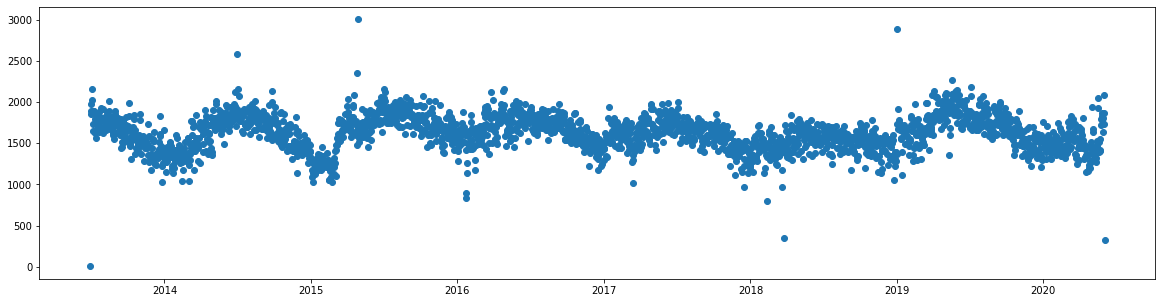

In [12]:
# print(mean2/mean1)
dfSum['y0'] = dfSum['y']
for i in range(2015,2019):
    Temp = dfSum[dfSum['ds'].dt.year==i]
    x = Temp['y'] * mean2/mean1
    dfSum.loc[dfSum.ds.dt.year==i,'y0'] = x
for i in range(2019,2021):
    Temp = dfSum[dfSum['ds'].dt.year==i]
    x = Temp['y'] * mean2/mean3
    dfSum.loc[dfSum.ds.dt.year==i,'y0'] = x

dfSum = dfSum.rename(columns={"y0": "y","y":"yOrg"})


fig, axs = plt.subplots(1,1,figsize=(20,5))
axs.plot_date(dfSum['ds'],dfSum['y'])
plt.show()

In [16]:
m = Prophet(changepoints=['2015-01-01','2019-01-01'])
m.fit(dfSum)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
# fig1 = m.plot(forecast)

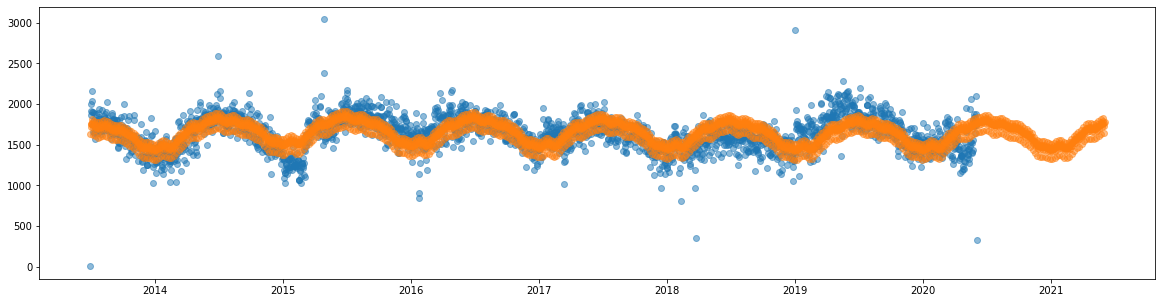

In [537]:
fig, axs = plt.subplots(1,1,figsize=(20,5))
axs.plot_date(dfSum['ds'],dfSum['y'],alpha = 0.5)
axs.plot_date(forecast['ds'],forecast['yhat'],alpha = 0.5)
# axs.set_ylim(0.5,1.5)
# axs.set_xlim([dt.date(2019, 1, 1), dt.date(2020, 12, 31)])
plt.show()

In [538]:
ND_file = 'Tract_ND_fin.csv' #'Tract_ND.csv'
PD_tract = pd.read_csv('Tract_PD2.csv') #('Tract_PD.csv')
ND_tract = pd.read_csv(ND_file) #
# ND_tract.info()

dfDaily = pd.DataFrame()
for cd in df.Census_Tracts.unique():    
    PD = PD_tract[PD_tract['census_tracts']==cd].Police_district
    policeD = (PD.tolist()[0])
    ND = ND_tract[ND_tract['census_tracts']==cd].New_district
    newD = (ND.tolist()[0])
    
    Temp = dfHighEmer[(dfHighEmer['Census_Tracts']==cd)]
    dfSumNew = Temp.groupby(pd.Grouper(key='CallDateTime', freq='D'))['Count'].sum()
    dfTemp = pd.DataFrame(dfSumNew) 
    dfTemp['Date'] = dfSumNew.index
    dfTemp['Census_Tracts'] = cd
    dfTemp['PoliceDistrict'] = policeD    
    dfTemp['New_district'] = newD
    
    dfDaily = dfDaily.append(dfTemp)
dfDaily

,Count,Date,Census_Tracts,PoliceDistrict,New_district
CallDateTime,,,,,
2013-07-01,6,2013-07-01,1503.00,Western,6.0
2013-07-02,6,2013-07-02,1503.00,Western,6.0
2013-07-03,9,2013-07-03,1503.00,Western,6.0
2013-07-04,5,2013-07-04,1503.00,Western,6.0
2013-07-05,1,2013-07-05,1503.00,Western,6.0
...,...,...,...,...,...
2020-05-28,1,2020-05-28,2720.05,Northwestern,5.0
2020-05-29,4,2020-05-29,2720.05,Northwestern,5.0
2020-05-30,1,2020-05-30,2720.05,Northwestern,5.0


In [296]:
dfDaily.to_csv('HighEmer.csv')

### Converting to format required for heriarchical time series modeling

In [297]:
labels0 = dfDaily.Census_Tracts.unique().astype(str).tolist()
labels = dfDaily.New_district.unique().astype(str).tolist()

dfhts = pd.DataFrame()
dfhts['total'] = dfDaily.groupby(pd.Grouper(key='Date', freq='D'))['Count'].sum()

for i in range(0,len(dfDaily.New_district.unique())):
    ND = dfDaily.New_district.unique()[i]
    newLabel = labels[i]
    Temp = dfDaily[dfDaily['New_district']==ND]
    dfhts[newLabel] = Temp.groupby(pd.Grouper(key='Date', freq='D'))['Count'].sum()

for i in range(0,len(dfDaily.Census_Tracts.unique())):
    CT = dfDaily.Census_Tracts.unique()[i]
    newLabel = labels0[i]
    Temp = dfDaily[dfDaily['Census_Tracts']==CT]
    dfhts[newLabel] = Temp.groupby(pd.Grouper(key='Date', freq='D'))['Count'].sum()
    
dfhts = dfhts.fillna(0)
dfhts = dfhts[1:-2]
dfhts

,total,6.0,4.0,2.0,9.0,5.0,8.0,0.0,1.0,3.0,...,2502.04,102.0,2707.02,2403.0,2707.01,2303.0,1308.04,2715.03,2703.02,2720.05
Date,,,,,,,,,,,,,,,,,,,,,
2013-07-01,1911,170.0,186.0,196.0,218.0,148,182,194.0,205.0,168.0,...,8.0,7.0,6.0,1.0,3.0,3.0,5.0,6.0,2.0,0.0
2013-07-02,1868,142.0,224.0,201.0,219.0,199,140,180.0,169.0,157.0,...,5.0,6.0,4.0,6.0,1.0,1.0,4.0,3.0,1.0,2.0
2013-07-03,1997,205.0,230.0,184.0,247.0,152,166,202.0,180.0,191.0,...,10.0,7.0,12.0,0.0,3.0,4.0,4.0,2.0,1.0,0.0
2013-07-04,2165,172.0,266.0,174.0,257.0,233,164,215.0,234.0,188.0,...,17.0,10.0,4.0,4.0,4.0,5.0,2.0,5.0,3.0,3.0
2013-07-05,2039,192.0,258.0,167.0,245.0,159,169,238.0,160.0,183.0,...,13.0,6.0,4.0,2.0,5.0,9.0,7.0,1.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-27,1026,120.0,94.0,110.0,93.0,101,110,111.0,59.0,82.0,...,3.0,3.0,1.0,0.0,4.0,6.0,1.0,0.0,1.0,4.0
2020-05-28,939,101.0,121.0,91.0,83.0,77,79,105.0,82.0,95.0,...,8.0,3.0,2.0,0.0,2.0,2.0,3.0,2.0,2.0,1.0
2020-05-29,1045,83.0,93.0,145.0,88.0,101,91,101.0,97.0,111.0,...,6.0,0.0,7.0,1.0,1.0,1.0,2.0,1.0,0.0,4.0


In [298]:
dfhtsNorm = pd.DataFrame()
k = 0
for i in [2013,2014]:
    if len(dfhtsNorm)!=0:        
        dTemp = dfhts[dfhts.index.year==i]* mean2/mean2
        dfhtsNorm = pd.concat([dfhtsNorm,dTemp])
    else:
        dfhtsNorm = dfhts[dfhts.index.year==i]* mean2/mean2
    k+=1
    
k = 0
for i in range(2015,2019):
    if len(dfhtsNorm)!=0:        
        dTemp = dfhts[dfhts.index.year==i]* mean2/mean1
        dfhtsNorm = pd.concat([dfhtsNorm,dTemp])
    else:
        dfhtsNorm = dfhts[dfhts.index.year==i]* mean2/mean1
    k+=1

k = 0
for i in range(2019,2021):
    if len(dfhtsNorm)!=0:        
        dTemp = dfhts[dfhts.index.year==i] * mean2/mean3
        dfhtsNorm = pd.concat([dfhtsNorm,dTemp])
    else:
        dfhtsNorm = dfhts[dfhts.index.year==i] * mean2/mean3
    k+=1

dfhtsNorm = dfhtsNorm[:-2]
dfhtsNorm

,total,6.0,4.0,2.0,9.0,5.0,8.0,0.0,1.0,3.0,...,2502.04,102.0,2707.02,2403.0,2707.01,2303.0,1308.04,2715.03,2703.02,2720.05
Date,,,,,,,,,,,,,,,,,,,,,
2013-07-01,1911.000000,170.000000,186.000000,196.000000,218.000000,148.000000,182.000000,194.000000,205.000000,168.000000,...,8.000000,7.000000,6.000000,1.000000,3.000000,3.000000,5.000000,6.000000,2.000000,0.000000
2013-07-02,1868.000000,142.000000,224.000000,201.000000,219.000000,199.000000,140.000000,180.000000,169.000000,157.000000,...,5.000000,6.000000,4.000000,6.000000,1.000000,1.000000,4.000000,3.000000,1.000000,2.000000
2013-07-03,1997.000000,205.000000,230.000000,184.000000,247.000000,152.000000,166.000000,202.000000,180.000000,191.000000,...,10.000000,7.000000,12.000000,0.000000,3.000000,4.000000,4.000000,2.000000,1.000000,0.000000
2013-07-04,2165.000000,172.000000,266.000000,174.000000,257.000000,233.000000,164.000000,215.000000,234.000000,188.000000,...,17.000000,10.000000,4.000000,4.000000,4.000000,5.000000,2.000000,5.000000,3.000000,3.000000
2013-07-05,2039.000000,192.000000,258.000000,167.000000,245.000000,159.000000,169.000000,238.000000,160.000000,183.000000,...,13.000000,6.000000,4.000000,2.000000,5.000000,9.000000,7.000000,1.000000,2.000000,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-25,1875.769107,180.059849,227.260004,157.333849,148.593079,174.815387,143.348618,206.282157,153.837541,220.267388,...,29.718616,1.748154,5.244462,3.496308,5.244462,1.748154,3.496308,0.000000,1.748154,1.748154
2020-05-26,1837.309722,183.556157,188.800618,188.800618,206.282157,164.326464,139.852310,225.511850,139.852310,139.852310,...,19.229693,3.496308,0.000000,8.740769,8.740769,1.748154,0.000000,0.000000,6.992615,3.496308
2020-05-27,1793.605875,209.778465,164.326464,192.296926,162.578310,176.563541,192.296926,194.045080,103.141079,143.348618,...,5.244462,5.244462,1.748154,0.000000,6.992615,10.488923,1.748154,0.000000,1.748154,6.992615


### Creating heriarchy to be supplied to time-series model

In [299]:
import json
from hts.hierarchy import HierarchyTree

ND_tract = pd.read_csv(ND_file)
New_districts = dfDaily.New_district.unique().astype(str)
Census_Tracts = dfDaily.Census_Tracts.unique().astype(str)

# Here we build the tree as a dictionary. Each node (key in dict) has a list of 
# children value in dict, which in turn may also be a key in the dict, and have 
# children as well 
total = {'total': list(New_districts)}
district_h = {k: list(ND_tract[ND_tract['New_district'].astype(str)==k]
                       ['census_tracts'].unique().astype(str)) 
              for k in New_districts}

hierarchy = {**total, **district_h}

with open('hierarchy.json', 'w') as j:
    json.dump(hierarchy, j)

ht = HierarchyTree.from_nodes(nodes=hierarchy, df=dfhts)

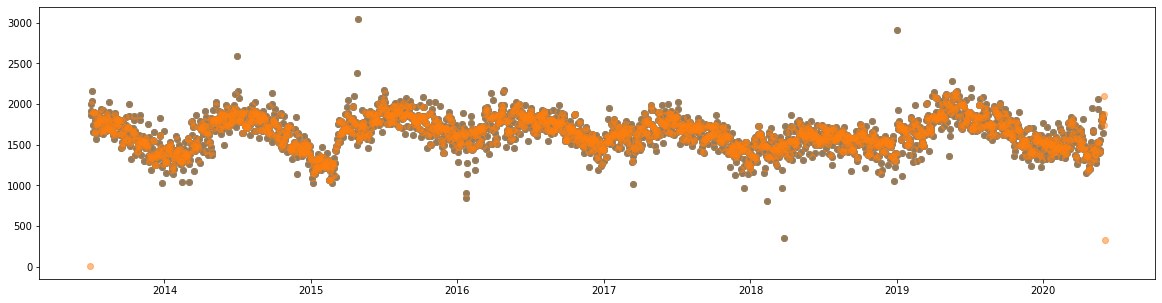

In [300]:
label = 'total'
dfTest = dfhtsNorm[label]
dfTest = dfTest.reset_index()
dfTest = dfTest.rename(columns={"Date": "ds",label:"y"})

fig, axs = plt.subplots(1,1,figsize=(20,5))
axs.plot_date(dfTest['ds'],dfTest['y'])
axs.plot_date(dfSum['ds'],dfSum['y'],alpha = 0.5)
plt.show()

### Predicting future call volumes using HTS
Time consumption is similar for heriarchical time-series vs fitting time series individually to each of the census tracts. This is because each time-series is fit individually (censustract, cluster and city). The specified revision method (OLS, found to be optimal for ours case), combines these time series in a way that improves accuracy while maintaining summing equality constraints.

Underlying time sereis model is FB-prophet due to its robust handling of trends and changepoints in data, the annual seasonlity is set to True by default, and doesnt need adjustment in our case. We are only interested in weekly data, therefore, holidays, weekends etc have not been incorporated as features. Prophet has issues with dealing with discontinuous data such as weekly, if it has not seen that particular day of the week during training. Therefore, data aggolemration to weeks is done post-prediction.

In [301]:
from hts import HTSRegressor
clf = HTSRegressor(model='prophet', revision_method='OLS', n_jobs=0)

In [269]:
dfUse = dfhtsNorm #[dfhtsNorm.index < '2018-01-01']
model = clf.fit(dfUse, hierarchy, disable_progressbar=True) 

In [270]:
preds = model.predict(steps_ahead=365, disable_progressbar=True)

INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x0000027392626688>


In [307]:
preds.to_csv('HTSPredictions.csv')

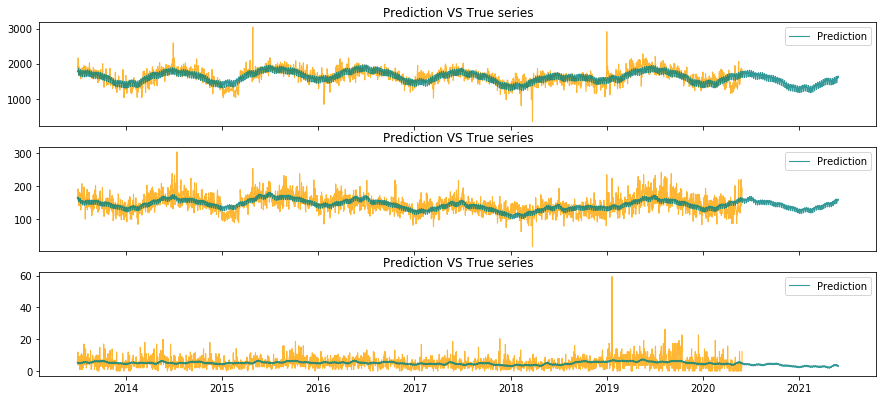

In [302]:
# preds.to_csv('Final_predictions.csv')
PLOT = [     
        'total',
        '3.0',
        '2707.02',
       ]

fig, axs = plt.subplots(len(PLOT), figsize=(15, 6.5), sharex=True)

dts = preds.index

for i, group in enumerate(PLOT):
    axs[i].plot(dfhtsNorm[group], 
            lw=1.1, 
            color='orange', # '#2ecc71', 
            alpha=0.8, 
            linestyle='-')#, marker='o',markersize=4)
    axs[i].plot(preds[group], 
            lw=1.1,
            color='teal',#'#e74c3c', 
            alpha=0.8, 
            label='Prediction')
    axs[i].legend()
    axs[i].set_title('Prediction VS True series')

### Defining MAPE (mean absolute percent error) for checking accuracy of model

In [474]:
def MAPE_func(pred, actual):
    # labels = (dfDaily.New_district.unique().astype(str).tolist())
# labels = labels + ['total']
    labels = dfDaily.Census_Tracts.unique().astype(str).tolist()
# print(labels)

    pred = pred[labels].reset_index()
    pred = pred.groupby(pd.Grouper(key='Date', freq='W')).sum()
    pred = pred.reset_index(drop=True)
    
    actual = actual[labels].reset_index()    
    actual = actual.groupby(pd.Grouper(key='Date', freq='W')).sum()    
    actual = actual.reset_index(drop=True)
    
    return ((abs(pred-actual)/(actual+1)*100)).mean().mean()

In [477]:
dfUse = dfhtsNorm

datesCV = dfUse.index 
nsteps = 130
nstart = int(len(datesCV)*0.8)

### Establishing baseline accuracy - 3 moths walk forward validation
The baseline / naive model assumes that the value next week will be the same as the value in teh same week last year (reasonable assumption - considering the annual seasonality of the trends)

In [411]:
j = 0
errorBase = [] #
for i in range(2*nsteps,len(datesCV),nsteps):
    endDate = min(i+nsteps, len(datesCV)-1)
    
    pred = dfUse[datesCV[i+1-365]:datesCV[endDate-365]]    
    actual = dfUse[datesCV[i+1]:datesCV[endDate]]
#     for i in range(0,len(pred)):
#         pred[i]=np.mean(pred)
    MAPE0 = MAPE_func(pred,actual)
    errorBase.append(MAPE0)
    print('step ' + str(j+1) + ' error = ' + str(MAPE0) + ' %')    
    j+=1
    
np.mean(errorBase)

step 1 error = nan %
step 2 error = 33.88582374098375 %
step 3 error = 34.86490726887232 %
step 4 error = 41.65618771592792 %
step 5 error = 36.78492494869327 %
step 6 error = 32.367291759498265 %
step 7 error = 31.790891010903223 %
step 8 error = 32.33869616867138 %
step 9 error = 34.83364647165214 %
step 10 error = 34.154825872124725 %
step 11 error = 42.149745126715025 %
step 12 error = 34.68230564535223 %
step 13 error = 31.234724486501836 %
step 14 error = 36.524739603088044 %
step 15 error = 33.90882820656882 %
step 16 error = 42.599185951629586 %
step 17 error = 45.05248763382707 %
step 18 error = 62.23967159543713 %


nan

In [412]:
def pred_to_pred(pred1):    
    pred2 = pred1
    pred2 = pred2.reset_index()
    pred2 = pred2.rename(columns={"index": "Date"})
    # pred2 = pred2.drop(['level_0'], axis=1)
    pred2 = pred2.set_index('Date')
    return pred2

### 3 month walk forward cross validation on 20% test set (split chronologically)

In [413]:
errorPred = []
j = 0
for i in range(2*nsteps,len(datesCV),nsteps):  #(nstart,len(datesCV)-nsteps,nsteps): #    
    endDate = min(i+nsteps, len(datesCV)-1)
    
    train = dfUse[datesCV[0]:datesCV[i]]    
    model = clf.fit(train, hierarchy, disable_progressbar=True)     
    pred1 = model.predict(steps_ahead=nsteps,disable_progressbar=True)[
        datesCV[i+1]:datesCV[endDate]]   
    actual1 = dfUse[datesCV[i+1]:datesCV[endDate]]
    pred2 = pred_to_pred(pred1)
    
    MAPE = MAPE_func(pred2,actual1)
    errorPred.append(MAPE)
    print('step ' + str(j) + ' error = ' + str(MAPE) + ' %')    
    j+=1
    
np.mean(errorPred)

INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000002733E2F8288>


step 0 error = 27.98103827184065 %


INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x00000273790FF508>


step 1 error = 39.38165311534403 %


INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000002739D2F0C48>


step 2 error = 35.25361658649487 %


INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000002730BE1B208>


step 3 error = 26.19323522002633 %


INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000002738D6BBF48>


step 4 error = 26.110773966799762 %


INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x0000027362B14688>


step 5 error = 29.315203416171062 %


INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x0000027304BE0BC8>


step 6 error = 30.43354499795834 %


INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000002730FD28988>


step 7 error = 26.21661253958886 %


INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x0000027326EC1A08>


step 8 error = 27.633343378315722 %


INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x0000027384B14DC8>


step 9 error = 26.12776350240145 %


INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x0000027311B4A6C8>


step 10 error = 25.726743008761318 %


INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x00000273046DDD48>


step 11 error = 27.621701681384636 %


INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x00000273498EF0C8>


step 12 error = 23.36720708583036 %


INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x00000273EC7E6388>


step 13 error = 29.837333905729967 %


INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000002735449B8C8>


step 14 error = 27.35502067070295 %


INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x00000273952D6148>


step 15 error = 36.0606817349089 %


INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x0000027338739188>


step 16 error = 41.108441254430936 %


INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x0000027378AD32C8>


step 17 error = 44.58587982372544 %


30.57276634224531

In [17]:
# df = pd.read_csv('Analysis911/911_Police_Calls_for_Service.csv')

In [14]:
# df['CallDateTime'] = pd.to_datetime(df['CallDateTime'])
# df = df.dropna(subset=['Census_Tracts'])
# df = df.dropna(subset=['PoliceDistrict'])
# df = df.dropna(subset=['Priority'])
# df['Count'] = 1

# def cen_tract(tract_string):
#     tract = float(str(tract_string).split()[2])
#     return tract

# df.Census_Tracts = df.apply(lambda x: cen_tract(x['Census_Tracts']),axis=1)
# df.info()

In [ ]:
# # df.Priority.unique()
# dfHighEmer = df[(df['Priority']!='Low') & (df['Priority']!='Non-Emergency')]# |
# #                (df['Priority']=='Emergency')]